In [1]:
import os
import numpy as np
from skimage import transform, io
import matplotlib.pyplot as plt
from shutil import copyfile
from tensorflow import keras
from keras import layers
from keras.preprocessing.image import ImageDataGenerator

Using TensorFlow backend.


In [2]:
DATASET_DIR = "./dataset/hgr"
BATCH_SIZE = 4

# build train batches
datagen = ImageDataGenerator()
train_batches = datagen.flow_from_directory(DATASET_DIR + '/train',
                                          interpolation='bicubic',
                                          class_mode='categorical',
                                          shuffle=True,
                                          batch_size=BATCH_SIZE)

#build test batches
datagen = ImageDataGenerator()
test_batches = datagen.flow_from_directory(DATASET_DIR + '/test',
                                          interpolation='bicubic',
                                          class_mode='categorical',
                                          shuffle=False,
                                          batch_size=BATCH_SIZE)

# build class dict
class_list = [cls_label for cls_label, idx in train_batches.class_indices.items()]

print("\ntraing batches number:", len(train_batches))
print("test batches number:", len(test_batches))
print("\nclass list:\n",class_list)

Found 16000 images belonging to 10 classes.
Found 4000 images belonging to 10 classes.

traing batches number: 4000
test batches number: 1000

class list:
 ['01_palm', '02_l', '03_fist', '04_fist_moved', '05_thumb', '06_index', '07_ok', '08_palm_moved', '09_c', '10_down']


x_train.shape:  (4, 256, 256, 3)
y_train.shape:  (4, 10)
['03_fist', '05_thumb', '01_palm', '01_palm']


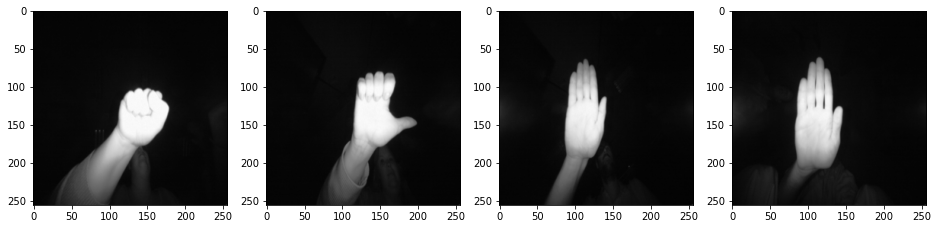

In [3]:
# show train batch
x_train_batch, y_train_batch = train_batches[0]
print("x_train.shape: ",x_train_batch.shape)
print("y_train.shape: ",y_train_batch.shape)

plt.figure(num=4, figsize=(16, 16))
for i,img in enumerate(x_train_batch):
    plt.subplot(1,4,i+1)
    plt.imshow(img.astype('uint8'))

labels = [class_list[np.where(label == 1)[0][0]] for label in y_train_batch]
print(labels)